# AWS Event Analysis

In [1]:
#Imports
import numpy as np
import pandas as pd
import json
from collections import defaultdict
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# What does our data look like?

In [12]:
page_ended_path = r'/scratch/PI/euan/projects/mhc/code/daniel_code/aws/tables/PageEndedActivities.txt'
with open(page_ended_path, 'r') as file:
    for i in range(3):
        print(file.readline())
        print()
        
    print("Each Record is a JSON with the structure:")
        
    line = json.loads(file.readline().rstrip())
    print(json.dumps(line, indent=4))

{"event_type": "PageEnded", "event_timestamp": 1518168269399, "arrival_timestamp": 1518168285800, "event_version": "3.0", "application": {"app_id": "4d29e476a66b4a5da830b905c8bc5e80", "cognito_identity_pool_id": "us-east-1:2c0f73f6-f544-4db3-93e3-7df5d4bbe0a5", "package_name": "edu.stanford.MyHeartCounts", "sdk": {"name": "aws-sdk-iOS", "version": "2.3.2"}, "title": "MyHeart", "version_name": "101", "version_code": "2.0.3"}, "client": {"client_id": "B6A8386D-D649-4342-9E81-848E8B5EB7B9", "cognito_id": "us-east-1:0d17bc07-9a72-4417-93e4-a857d9bff128"}, "device": {"locale": {"code": "en_GB", "country": "GB", "language": "en"}, "make": "apple", "model": "iPhone", "platform": {"name": "iOS", "version": "11.2.5"}}, "session": {"session_id": "c8bc5e80-8B5EB7B9-20180209-092338376", "start_timestamp": 1518168218377}, "attributes": {"duration": "15", "pageName": "APCActivityTrackingStepViewController", "version": "2.0.3 (101)"}, "metrics": {}}


{"event_type": "PageEnded", "event_timestamp": 15

In [3]:
#Anna's function to map AWS client IDs to healthcodes, returns dict
def map_aws_to_healthcode(source_table = r'/scratch/PI/euan/projects/mhc/code/daniel_code/aws/tables/cardiovascular-AwsClientIdTask-v1.tsv'): 
    client_id_to_health_code_id=dict()
    #read in the data 
    dtype_dict=dict() 
    dtype_dict['names']=('skip',
                         'recordId',
                         'appVersion',
                         'phoneInfo',
                         'uploadDate',
                         'healthCode',
                         'externalId',
                         'dataGroups',
                         'createdOn',
                         'createdOnTimeZone',
                         'userSharingScope',
                         'validationErrors',
                         'AwsClientId')
    dtype_dict['formats']=('S36',
                           'S36',
                           'S36',
                           'S36',
                           'S36',
                           'S36',
                           'S36',
                           'S36',
                           'S36',
                           'S36',
                           'S36',
                           'S36',
                           'S36')
    try: 
        data=np.genfromtxt(source_table,
                           names=dtype_dict['names'],
                           dtype=dtype_dict['formats'],
                           delimiter='\t',
                           skip_header=True,
                           loose=True,
                           invalid_raise=False)
    except:
        print("failed to load file:"+str(source_table))
        raise Exception() 

    #create a mapping of client id to healthCode 
    for line in data: 
        client_id_to_health_code_id[line['AwsClientId'].decode('UTF-8')] = line['healthCode'].decode('UTF-8')    
    return client_id_to_health_code_id

# Graphing and Analytics Functions

In [2]:
def reject_outliers(data, m=3):
    outliers = data[np.logical_or(abs(data - np.mean(data)) >= m * np.std(data), data <= 2)]
    clean = data[np.logical_and(abs(data - np.mean(data)) < m * np.std(data), data>2)]
    
    num_less = (data <= 2).sum()#(outliers < np.mean(data)).sum()
    num_more = (outliers > np.mean(data)).sum()

    return clean, num_less, num_more

def page_duration():
    '''generates a table and figure describing average time spent on an activity based on activity'''
    
    print("Generating page duration table")
    
    freq = defaultdict(list)
    
    with open(r'/scratch/PI/euan/projects/mhc/code/daniel_code/aws/tables/PageEndedActivities.txt', 'r') as file:
        print("Loading in data")
        for line in file:
            data = json.loads(line.rstrip())
            dur = int(data["attributes"]["duration"])
            act = data["attributes"]["pageName"]
            
            freq[act].append(dur)
            
    print("Finished loading the data - beginning parsing")
    #Describe all the results
    for key in freq.keys():
        print("Stats for activity {}".format(key))
        print(stats.describe(freq[key]))
        
        #clean up the data a little
        clean, num_less, num_more = reject_outliers(np.array(freq[key]))
        
        #Plot everything
        fig = plt.hist(clean)
        plt.title('Duration spent on activity {} \n {} 2 or less, {} high outliers'.format(key, num_less, num_more))
        plt.xlabel("Duration")
        plt.ylabel("# Occurences")
        plt.savefig("/scratch/PI/euan/projects/mhc/code/daniel_code/aws/figures/duration_{}.png".format(key))
        plt.clf()

In [ ]:
def age_activity(healthcode_map, uniq_only=True):

    '''Generates a figure and table of the average duration spent on various activities depending on age'''
    
    print("Generating age activity table")

    
    age_table = pd.read_csv(r'tables/demographics_summary_v2.age.tsv', delimiter='\t').set_index('Subject')
    
    freq = defaultdict(list)
    uniq = set()
    
    with open(r'/scratch/PI/euan/projects/mhc/code/daniel_code/aws/tables/PageEndedActivities.txt', 'r') as file:
        print("Loading in data")
        for line in file:
            data = json.loads(line.rstrip())
            aws_id = data["client"]["client_id"]
            act = data["attributes"]["pageName"]
            
            #Include only never before seen ids for each activity
            if(uniq_only):
                if((aws_id, act) in uniq):
                    continue
                else:
                    uniq.add((aws_id, act))
            
            #Get the age
            try:
                healthcode = healthcode_map[aws_id]
                age = int(age_table.loc[healthcode, 'Agex'])
                
                freq[act].append(age)
            except KeyError:
                print("AWS_id not found {}".format(aws_id))
            
    print("Finished loading the data - beginning parsing")
    #Describe all the results
    for key in freq.keys():
        print("Stats for activity {}".format(key))
        print(stats.describe(freq[key]))
        
        
        #Plot everything
        fig = plt.hist(freq[key])
        plt.title('Age spent on activity {}'.format(key))
        plt.xlabel("Age")
        plt.ylabel("# Occurences")
        plt.savefig("/scratch/PI/euan/projects/mhc/code/daniel_code/aws/figures/age_{}.png".format(key))
        plt.clf()

In [ ]:
def usage_graph(healthcode_map):

    '''
    Generates a figure of overall activities per person
    Returns healthcodes of the 10 most active people
    '''
    
    usage = defaultdict(int)
    invalid_aws_id = set()
    
    with open(r'/scratch/PI/euan/projects/mhc/code/daniel_code/aws/tables/PageEndedActivities.txt', 'r') as file:
        print("Loading in data")
        for line in file:
            data = json.loads(line.rstrip())
            aws_id = data["client"]["client_id"]
            

            #Get the healthcode
            try:
                healthcode = healthcode_map[aws_id] 
                
                #Count usage
                usage[healthcode] += 1
            except KeyError:
                #print("AWS_id not found {}".format(aws_id))
                invalid_aws_id.add(aws_id)
            
    print("There were {} distinct invalid aws ids".format(len(invalid_aws_id)))
    print("Finished loading the data - beginning graphing")
        
    #Plot everything
    fig = plt.hist(list(usage.values()))
    plt.title("Activity of users")
    plt.xlabel("# activities")
    plt.ylabel("# users")
    plt.savefig("/scratch/PI/euan/projects/mhc/code/daniel_code/aws/figures/overall_activity.png")
    
    print("Our 10 most active healthcodes were:")
    most_active = sorted(usage, key=usage.get, reverse=True)[:10]
    for i in range(10):
        print("{} with {} activities".format(most_active[i], usage[most_active[i]]))

    return most_active


In [ ]:
def timeline(filename, dates, names):
    
    '''
    timeline(filename, dates, names)
    Function which saves a figure of a timeline of events
    
    filename - unique string to append
    dates - array of datetine objects of each event
    names - array of labels of events
    '''
    
    import matplotlib.dates as mdates
    from datetime import datetime
    
    print("Saving timeline {}".format(filename))
    
    # Choose some nice levels
    levels = np.tile(np.linspace(-5, 5, num=50),
                     int(np.ceil(len(dates)/50)))[:len(dates)]
    
    # Create figure and plot a stem plot with the date
    fig, ax = plt.subplots(figsize=(200, 40))
    ax.set(title="Activity of user {}".format(filename))
    
    markerline, stemline, baseline = ax.stem(dates, levels,
                                             linefmt="C3-", basefmt="k-")
    
    plt.setp(markerline, mec="k", mfc="w", zorder=3)
    
    # Shift the markers to the baseline by replacing the y-data by zeros.
    markerline.set_ydata(np.zeros(len(dates)))
    
    # annotate lines
    vert = np.array(['top', 'bottom'])[(levels > 0).astype(int)]
    for d, l, r, va in zip(dates, levels, names, vert):
        ax.annotate(r, xy=(d, l), xytext=(-3, np.sign(l)*3),
                    textcoords="offset points", va=va, ha="right")
    
    # format xaxis with 4 month intervals
    ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=4))
    ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
    
    # remove y axis and spines
    ax.get_yaxis().set_visible(False)
    for spine in ["left", "top", "right"]:
        ax.spines[spine].set_visible(False)
    
    ax.margins(y=0.1)
    plt.savefig("/scratch/PI/euan/projects/mhc/code/daniel_code/aws/figures/user_timeline_{}.png".format(filename))
    plt.close()
    
    #Plot histogram of dates
    df = pd.DataFrame(np.ones(len(dates)), pd.DatetimeIndex(dates, name='dates'))
    fig = df.resample('D').sum().hist()
    plt.title("Activity of user {}".format(filename))
    plt.ylabel("# activities")
    plt.xlabel("Date")
    plt.savefig("/scratch/PI/euan/projects/mhc/code/daniel_code/aws/figures/user_hist_{}.png".format(filename))
    plt.close()

def journey_map(healthcode_map, healthcodes):

    '''
    Looks at the events and behavior of a specific set of healthcodes
    '''
    from datetime import datetime

    events = defaultdict(list)
    times = defaultdict(list)
    invalid_aws_id = set()
    
    with open(r'/scratch/PI/euan/projects/mhc/code/daniel_code/aws/tables/PageEndedActivities.txt', 'r') as file:
        print("Loading in data")
        for line in file:
            data = json.loads(line.rstrip())
            aws_id = data["client"]["client_id"]
            

            #Get the healthcode
            try:
                healthcode = healthcode_map[aws_id] 
                
                #Store events
                if healthcode in healthcodes:
                    act = data["attributes"]["pageName"]
                    #Convert to seconds instead of milliseconds timestamp
                    time = datetime.fromtimestamp(data["event_timestamp"]/1000)

                    events[healthcode].append(act[3:-14])
                    times[healthcode].append(time)
            except KeyError:
                invalid_aws_id.add(aws_id)
            
    print("There were {} distinct invalid aws ids".format(len(invalid_aws_id)))
    print("Finished loading the data - beginning graphing")
    
    for healthcode in healthcodes:
        timeline(healthcode, dates = times[healthcode], names = events[healthcode])

# Activity & Usage

In [2]:
freq = defaultdict(list)

with open(r'/scratch/PI/euan/projects/mhc/code/daniel_code/aws/tables/PageEndedActivities.txt', 'r') as file:
    print("Loading in data")
    for line in file:
        data = json.loads(line.rstrip())
        dur = int(data["attributes"]["duration"])
        act = data["attributes"]["pageName"]

        freq[act].append(dur)

print("Finished loading the data - beginning parsing")
#Describe all the results
for key in freq.keys():
    print("Stats for activity {}".format(key))
    print(stats.describe(freq[key]))

    #clean up the data a little
    #clean, num_less, num_more = reject_outliers(np.array(freq[key]))

    #Plot everything
    #fig = plt.hist(clean)
    #plt.title('Duration spent on activity {} \n {} 2 or less, {} high outliers'.format(key, num_less, num_more))
    #plt.xlabel("Duration")
    #plt.ylabel("# Occurences")
    #plt.savefig("/scratch/PI/euan/projects/mhc/code/daniel_code/aws/figures/duration_{}.png".format(key))
    #plt.clf()

Loading in data
Finished loading the data - beginning parsing
Stats for activity APCActivityTrackingStepViewController
DescribeResult(nobs=69723, minmax=(0, 416068), mean=703.7706208855041, variance=69401467.95316455, skewness=18.01693301657169, kurtosis=482.6192995601215)
Stats for activity APCSpinnerViewController
DescribeResult(nobs=349663, minmax=(0, 2137742), mean=9.443366898985595, variance=13072625.702256085, skewness=591.1110114159903, kurtosis=349491.7435464086)
Stats for activity APCActivitiesViewController
DescribeResult(nobs=277228, minmax=(0, 2137773), mean=2196.898563637151, variance=229540901.4262266, skewness=21.599302435236936, kurtosis=1712.015150489339)
Stats for activity APHDailySurveyTaskViewController
DescribeResult(nobs=91297, minmax=(2, 267166), mean=83.85133136904827, variance=4743123.178289527, skewness=60.28944818767026, kurtosis=4789.012334885904)
Stats for activity APHSevenDayFitnessAllocationTaskViewController
DescribeResult(nobs=71539, minmax=(0, 416070),

In [4]:
list(freq.keys())

['APCActivityTrackingStepViewController',
 'APCSpinnerViewController',
 'APCActivitiesViewController',
 'APHDailySurveyTaskViewController',
 'APHSevenDayFitnessAllocationTaskViewController',
 'APCNewsFeedViewController',
 'APCPasscodeViewController',
 'APHDashboardViewController',
 'APHAchievementPopupViewController',
 'APCWebViewController',
 'APHProfileViewController',
 'APCSignUpPermissionsViewController',
 'APHDietSurveyViewController',
 'APHTwentyThreeAndMeCustomerStepController',
 'APHParQQuizTaskViewController',
 'APCGenericSurveyTaskViewController',
 'APHCoachingConsentViewController',
 'APHHeartAgeTaskViewController',
 'APHCoachingDialogViewController',
 'APHFitnessTaskViewController',
 'APHGetStartedTaskViewController',
 'APHEmailVerifyViewController',
 'APHStudyOverviewCollectionViewController',
 'APCSignupPasscodeViewController',
 'APCSignUpMedicalInfoViewController',
 'APCSignUpGeneralInfoViewController',
 'APHInclusionCriteriaViewController',
 'APCEligibleViewController',

Loading in data
There were 7309 distinct invalid aws ids
Finished loading the data - beginning graphing


Text(0, 0.5, '# users')

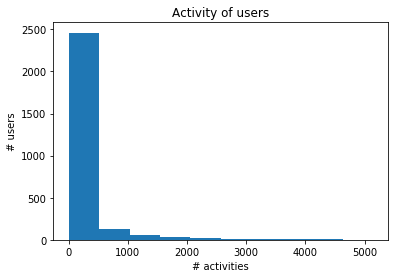

In [4]:
usage = defaultdict(int)
invalid_aws_id = set()
healthcode_map = map_aws_to_healthcode()

with open(r'/scratch/PI/euan/projects/mhc/code/daniel_code/aws/tables/PageEndedActivities.txt', 'r') as file:
    print("Loading in data")
    for line in file:
        data = json.loads(line.rstrip())
        aws_id = data["client"]["client_id"]
            

        #Get the healthcode
        try:
            healthcode = healthcode_map[aws_id] 
                
            #Count usage
            usage[healthcode] += 1
        except KeyError:
            #print("AWS_id not found {}".format(aws_id))
            invalid_aws_id.add(aws_id)
            
print("There were {} distinct invalid aws ids".format(len(invalid_aws_id)))
print("Finished loading the data - beginning graphing")
        
#Plot everything
fig = plt.hist(list(usage.values()))
plt.title("Activity of users")
plt.xlabel("# activities")
plt.ylabel("# users")
#plt.savefig("/scratch/PI/euan/projects/mhc/code/daniel_code/aws/figures/overall_activity.png")

In [27]:
freq = defaultdict(list)
ids = defaultdict(set)
interesting_activities = set(['APCActivityTrackingStepViewController',
 'APHDailySurveyTaskViewController',
 'APHSevenDayFitnessAllocationTaskViewController',
 'APCNewsFeedViewController',
 'APCWebViewController',
 'APHProfileViewController',
 'APHDietSurveyViewController',
 'APHTwentyThreeAndMeCustomerStepController',
 'APHParQQuizTaskViewController',
 'APCGenericSurveyTaskViewController',
 'APHCoachingConsentViewController',
 'APHHeartAgeTaskViewController',
 'APHCoachingDialogViewController',
 'APHFitnessTaskViewController',
 'APHGetStartedTaskViewController',
 'APHStudyOverviewCollectionViewController',
 'APCSignUpMedicalInfoViewController',
 'APCSignUpGeneralInfoViewController',
 'APHInclusionCriteriaViewController',
 'APCEligibleViewController',
 'APCPermissionPrimingViewController',
 'APHTwentyThreeAndMeNot23UserController',
 'APHWalkTestViewController',
 'APHHeartAgeResultsViewController',
 'APHYouVsOthersExpandedViewController',
 'APCLearnMasterViewController',
 'APHCardiovascularHealthSurveyController',
 'APHWellBeingSurveyController',
 'APCStudyDetailsViewController',
 'APH23andmeProfileTableViewController',
 'APHTwentyThreeAndMeConsentStepController',
 'APHTwentyThreeAndMePermissionStepController',
 'APHDashboardMoreInfoViewController',
 'APHCoachingNotificationViewController',
 'APHAchievementsTableViewController',
 'APHAchievementDetailViewController',
 'APCIntroVideoViewController',
 'APCSharingOptionsViewController',
 'APCAllSetContentViewController',
 'APHTwentyThreeAndMeLearnMoreViewController',
 'APCWithdrawCompleteViewController',
 'APCWithdrawSurveyViewController',
 'APCWithdrawDescriptionViewController',
 'APCInEligibleViewController',
 'APHOnboardingLearnMoreViewController',
 'APHRiskEstimatorWebViewController',
 'APCShareViewController',
 'APHHeartAgeLearnMoreViewController',
 'APHIntroPurposeContainedTableTableViewController'])


with open(r'/scratch/PI/euan/projects/mhc/code/daniel_code/aws/tables/PageEndedActivities.txt', 'r') as file:
    print("Loading in data")
    for line in file:
        data = json.loads(line.rstrip())
        act = data["attributes"]["pageName"]
        
        if act not in interesting_activities:
            continue
            
        dur = int(data["attributes"]["duration"])
        aws_id = data["client"]["client_id"]

        #Get the healthcode
        #try:
        #    healthcode = healthcode_map[aws_id] 
        #        
        #    #Count usage
        #    usage[healthcode] += 1
        #except KeyError:
        #    #print("AWS_id not found {}".format(aws_id))
        #    invalid_aws_id.add(aws_id)
            
        freq[act].append(dur)
        ids[act].add(aws_id)

print("Finished loading the data - beginning parsing")
names= []
values= []
#Get counts
for key in ids.keys():
    
    pretty_name = key[3:-14]
    
    names.append(pretty_name)
    values.append(len(ids[key]))
    
print('All Done.')

Loading in data
Finished loading the data - beginning parsing
All Done.


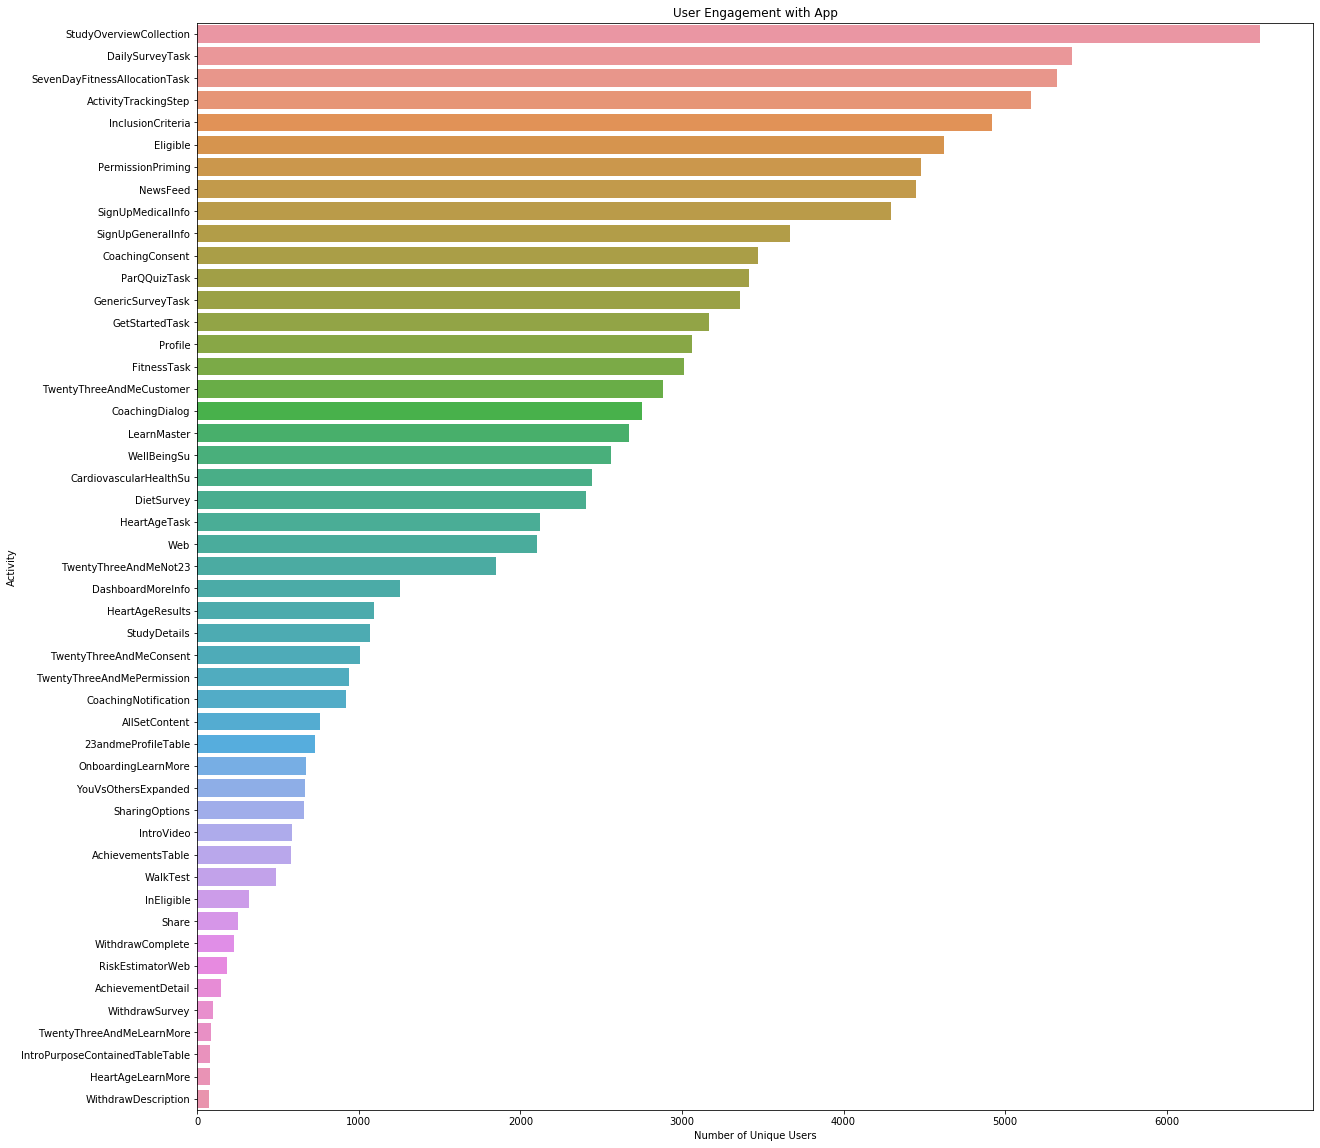

In [28]:
plt.figure(figsize=(20, 20))
plt.title("User Engagement with App")
plt.xlabel("Number of Unique Users")
plt.ylabel("Activity")
sns.barplot(x=values, y = names, order = [x for _, x in sorted(zip(values,names), reverse = True)])
plt.show()

In [14]:
len(ids['APHDailySurveyTaskViewController'])

5417

In [ ]:
for ppl in ids:
    print(ppl, len(ids[ppl]))

# Sharing Scope

In [2]:
sharing = pd.read_csv("/scratch/PI/euan/projects/mhc/code/daniel_code/aws/tables/sharing_scope.csv").set_index("healthCode")
#Get an itemp like
sharing.loc['cd246034-c5dd-4bb9-9e38-f03c1da1beda', "userSharingScope"]

'SPONSORS_AND_PARTNERS'

In [3]:
# Count how many opt for what
options = sharing.loc[:, "userSharingScope"].unique()
print("Available options were {}".format(options))
print("{} people picked {}".format((sharing.loc[:, "userSharingScope"] == 'SPONSORS_AND_PARTNERS').sum(), 'SPONSORS_AND_PARTNERS'))
print("{} people picked {}".format((sharing.loc[:, "userSharingScope"] == 'ALL_QUALIFIED_RESEARCHERS').sum(), 'ALL_QUALIFIED_RESEARCHERS'))

sponsor_hcs = np.array(sharing[sharing.loc[:, "userSharingScope"] == 'SPONSORS_AND_PARTNERS'].index)
all_hcs = np.array(sharing[sharing.loc[:, "userSharingScope"] == 'ALL_QUALIFIED_RESEARCHERS'].index)

Available options were ['SPONSORS_AND_PARTNERS' 'ALL_QUALIFIED_RESEARCHERS']
1844 people picked SPONSORS_AND_PARTNERS
5335 people picked ALL_QUALIFIED_RESEARCHERS


In [4]:
sponsor_hcs

array(['cd246034-c5dd-4bb9-9e38-f03c1da1beda',
       '4db3ff74-3d41-41ff-9403-1a3ae2342296',
       '5b028451-acba-4a96-956a-f99562fd3dff', ...,
       '641e33b6-120a-4197-9788-c03b41f8354e',
       '7a664180-bffa-40f7-85e9-7740314312b5',
       'f0367d99-5813-4f34-8df0-83fbb95e152a'], dtype=object)

In [5]:
#Demographics of these healthcodes
table_path = "/scratch/PI/euan/projects/mhc/code/daniel_code/tables/all.tsv"
demog_df = pd.read_csv(table_path, 
                           header=None,
                           names=["Healthcode", "Age", "Gender", "Ethnicity", "Version"], 
                           delimiter='\t')
#Drop duplicates
demog_df = demog_df.set_index('Healthcode')
demog_df = demog_df.loc[~demog_df.index.duplicated(keep='first')]

#Remove invalid genders
demog_df = demog_df[(demog_df.Gender =='Male') | (demog_df.Gender == 'Female')]

#Remove invalid ages
demog_df = demog_df[demog_df.Age.apply(lambda x: str(x).isdigit())]

demog_df

,Age,Gender,Ethnicity,Version
Healthcode,,,,
d04c954e-979b-4b24-999a-aa4c4a9f90e9,35,Male,NaN,"version 1.0.10, build 1"
3f56729c-2ad7-4ec1-95f7-22cb403a865f,20,Male,NaN,"version 1.0.10, build 1"
c79f6230-19f4-4666-af4e-eb960a910777,37,Male,White,"version 1.0.6, build 9"
5c296dd4-2920-4a82-889e-a4217760d5b5,19,Male,White,"version 1.0, build 5.1"
38dd0d13-3c47-4b1f-8621-f8bb94956e85,54,Male,White,"version 1.0, build 5.1"
b3ddbb8c-0500-4f85-8f2c-12102149ea79,21,Female,NaN,"version 1.0.10, build 1"
72c7ce93-ef49-4cb6-89ee-7b95df57e46d,26,Male,White,"version 1.0.3, build 1"
df52b218-5898-4509-8bbe-ca981f06e4c5,29,Male,NaN,"version 1.0.10, build 1"
93f3b6a4-eb63-42e4-ac53-0620eef70e92,24,Female,NaN,"version 1.6.0, build 1"


In [17]:
demog_df = pd.read_csv(table_path, 
                           header=None,
                           names=["Healthcode", "Age", "Gender", "Ethnicity", "Version"], 
                           delimiter='\t')

In [19]:
demog_df.Gender.unique()

array(['Male', 'Female', '[]', nan, 'HKBiologicalSexOther', 'Sex'],
      dtype=object)

In [6]:
valid_sponsor_hcs = sponsor_hcs[np.isin(sponsor_hcs, demog_df.index)]
print(f"{valid_sponsor_hcs.shape[0]} out of {sponsor_hcs.shape[0]} healthcodes are in the demographics table.")
valid_all_hcs = all_hcs[np.isin(all_hcs, demog_df.index)]
print(f"{valid_all_hcs.shape[0]} out of {all_hcs.shape[0]} healthcodes are in the demographics table.")

1366 out of 1844 healthcodes are in the demographics table.
4127 out of 5335 healthcodes are in the demographics table.


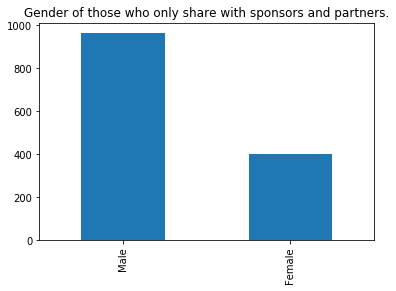

Male      0.704978
Female    0.295022
Name: Gender, dtype: float64


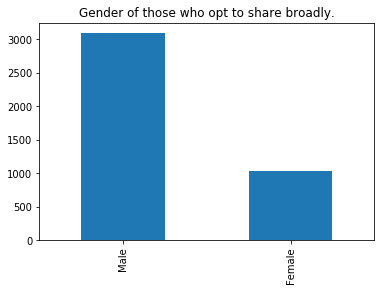

Male      0.748728
Female    0.251272
Name: Gender, dtype: float64


In [7]:
plt.figure()
demog_df.loc[valid_sponsor_hcs].Gender.dropna().value_counts().plot(kind='bar')
plt.title("Gender of those who only share with sponsors and partners.")
plt.show()
print(demog_df.loc[valid_sponsor_hcs].Gender.dropna().value_counts() / demog_df.loc[valid_sponsor_hcs].shape[0])

plt.figure()
demog_df.loc[valid_all_hcs].Gender.dropna().value_counts().plot(kind='bar')
plt.title("Gender of those who opt to share broadly.")
plt.show()
print(demog_df.loc[valid_all_hcs].Gender.dropna().value_counts() / demog_df.loc[valid_all_hcs].shape[0])

In [13]:
demog_df.loc[np.concatenate((valid_sponsor_hcs, valid_all_hcs))].Gender.dropna().value_counts()

Male      4053
Female    1440
Name: Gender, dtype: int64

In [10]:
demog_df.loc[valid_sponsor_hcs].Gender.dropna().value_counts()

Male      963
Female    403
Name: Gender, dtype: int64

In [11]:
demog_df.loc[valid_all_hcs].Gender.dropna().value_counts()

Male      3090
Female    1037
Name: Gender, dtype: int64

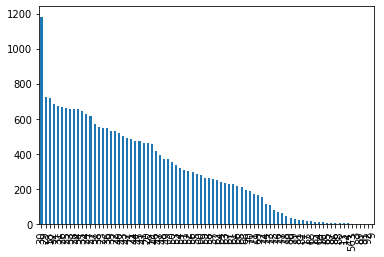

In [15]:
demog_df.Age.dropna().value_counts().plot(kind='bar')

In [16]:
demog_df.Age.dropna().min()

'13'

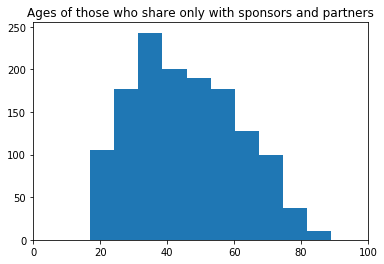

Average: 45.64714494875549


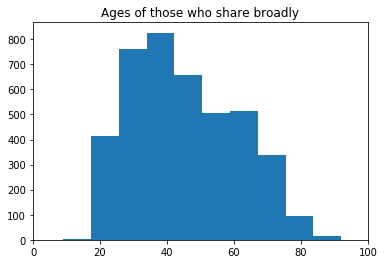

Average: 45.07681124303368


In [54]:
plt.figure()
ages = demog_df.loc[valid_sponsor_hcs].Age.dropna().astype('int32').values
plt.hist(ages)
plt.xlim([0, 100])
plt.title("Ages of those who share only with sponsors and partners")
plt.show()
print(f"Average: {np.mean(ages)}")

plt.figure()
ages = demog_df.loc[valid_all_hcs].Age.dropna().astype('int32').values
plt.hist(ages)
plt.xlim([0, 100])
plt.title("Ages of those who share broadly")
plt.show()
print(f"Average: {np.mean(ages)}")



In [ ]:
sponsor_age = demog_df.loc[valid_sponsor_hcs].Age.value_counts().plot(kind='bar')

# Video Watch Analysis

In [3]:
with open(r'/scratch/PI/euan/projects/mhc/code/daniel_code/aws/tables/VideoWatchActivities.txt', 'r') as file:
    print("Loading in video watch data")
    for line in file:
        print(line)
        break

Loading in video watch data
{"event_type": "VideoWatch", "event_timestamp": 1518181620627, "arrival_timestamp": 1518181802544, "event_version": "3.0", "application": {"app_id": "4d29e476a66b4a5da830b905c8bc5e80", "cognito_identity_pool_id": "us-east-1:2c0f73f6-f544-4db3-93e3-7df5d4bbe0a5", "package_name": "edu.stanford.MyHeartCounts", "sdk": {"name": "aws-sdk-iOS", "version": "2.3.2"}, "title": "MyHeart", "version_name": "101", "version_code": "2.0.3"}, "client": {"client_id": "E050292C-4CD7-42F5-8B22-4404EEB36ACB", "cognito_id": "us-east-1:c964ffaf-63ed-4a51-89d0-5fe3033f7dcb"}, "device": {"locale": {"code": "en_US", "country": "US", "language": "en"}, "make": "apple", "model": "iPhone", "platform": {"name": "iOS", "version": "11.2.5"}}, "session": {"session_id": "c8bc5e80-EEB36ACB-20180209-130655468", "start_timestamp": 1518181615469}, "attributes": {"version": "2.0.3 (101)"}, "metrics": {}}



In [14]:
#Examine video completion
def video_watch():
    
    print("Generating video watch table")
    
    start_times = defaultdict(list)
    end_times = defaultdict(list)
    
    with open(r'/scratch/PI/euan/projects/mhc/code/daniel_code/aws/tables/VideoWatchActivities.txt', 'r') as file:
        print("Loading in video watch data")
        for line in file:
            
            data = json.loads(line.rstrip())
            aws_id = data["client"]["client_id"]
            time = int(data["event_timestamp"])
            
            start_times[aws_id].append(time)
            
    with open(r'/scratch/PI/euan/projects/mhc/code/daniel_code/aws/tables/VideoCompletedActivities.txt', 'r') as file:
        print("Loading in video completed data")
        for line in file:
            
            data = json.loads(line.rstrip())
            aws_id = data["client"]["client_id"]
            time = int(data["event_timestamp"])
            
            end_times[aws_id].append(time)
            
    print("Finished loading the data - beginning parsing")
    #Describe all the results
    multi_start_cnt = 0
    multi_finish_cnt = 0
    incomplete_cnt = 0
    one_watch_cnt = 0
    watch_times = []
    for key in start_times.keys():

        # Count the incomplete folks
        if key not in end_times:
            incomplete_cnt += 1
            
        # Count the folks who started multiple times?
        elif len(start_times[key]) >= 2:
            multi_start_cnt += 1
            if len(end_times[key]) >= 2:
                multi_finish_cnt += 1
                            
        elif len(end_times[key]) >= 2:
            print(f"Error, user {key} has >= 2 ends but only 1 start")
            
        # Profile the folks who watched the video once
        else:
            one_watch_cnt += 1
            watch_times.append(end_times[key][0] - start_times[key][0])
        
    #Clean up the data
    clean, num_less, num_more = reject_outliers(np.array(watch_times))
    
    print(f"There were {multi_start_cnt} people that started a video multiple times, " 
          + f"and {multi_finish_cnt} people who finished multiple videos.")
    print(f"There were {incomplete_cnt} people who started but didn't finish a video. ")
    print(f"Amongst {one_watch_cnt} people who watched once," 
          + f" average video watch length is {np.average(clean)}, with " + 
          f"{num_less} outliers below and {num_more} outliers above.")
    
    
    #Plot everything
    fig = sns.distplot(clean, kde=False, norm_hist = False)
    plt.title("Time spent watching the video")
    plt.xlabel("Duration")
    plt.ylabel("# Occurences")
    plt.savefig("/scratch/PI/euan/projects/mhc/code/daniel_code/aws/figures/video_watch.png")
    plt.show()
    
        
    #Plot small bit
    plt.figure()
    fig = sns.distplot(clean[clean < 50000], kde=False, norm_hist = False)
    plt.title("Time spent watching the video (zoomed)")
    plt.xlabel("Duration")
    plt.ylabel("# Occurences")
    plt.savefig("/scratch/PI/euan/projects/mhc/code/daniel_code/aws/figures/video_watch_zoom.png")
    plt.show()
    
            
    #Plot small bit
    plt.figure()
    fig = sns.distplot(clean[np.logical_and(clean > 34000, clean < 36000)], kde = False, norm_hist= False)
    plt.title("Time spent watching the video (zoom zoomed)")
    plt.xlabel("Duration")
    plt.ylabel("# Occurences")
    #plt.savefig("/scratch/PI/euan/projects/mhc/code/daniel_code/aws/figures/duration_{}.png".format(key))
    plt.show()

Generating video watch table
Loading in video watch data
Loading in video completed data
Finished loading the data - beginning parsing
Error, user 964D7CD2-3E11-41D1-ADF9-D3480A8EB271 has >= 2 ends but only 1 start
Error, user 7B5D89B0-CF5A-4060-B8DE-10CB803AF091 has >= 2 ends but only 1 start
There were 134 people that started a video multiple times, and 125 people who finished multiple videos.
There were 62 people who started but didn't finish a video. 
Amongst 448 people who watched once, average video watch length is 29545.267415730337, with 0 outliers below and 3 outliers above.


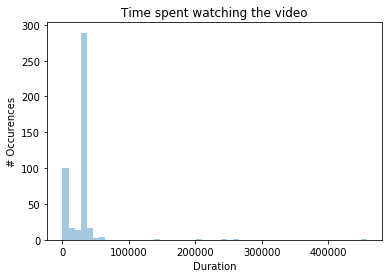

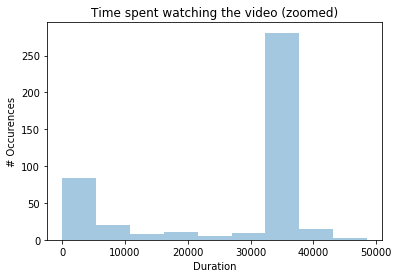

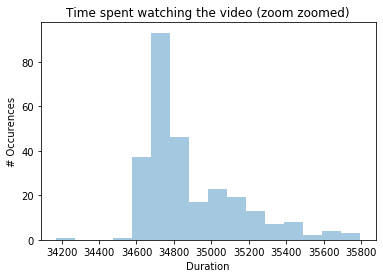

In [15]:
video_watch()

# Eligibility Test Analysis

In [12]:
start_time_map = defaultdict(list)
pass_time_map = defaultdict(list)
fail_time_map = defaultdict(list)

   
with open(r'/scratch/PI/euan/projects/mhc/code/daniel_code/aws/tables/EligibilityTest.txt', 'r') as file:
    print("Loading in Eligibility Start data")
    for line in file:
            
        data = json.loads(line.rstrip())
        aws_id = data["client"]["client_id"]
        time = int(data["event_timestamp"])
            
        start_time_map[aws_id].append(time)
        

with open(r'/scratch/PI/euan/projects/mhc/code/daniel_code/aws/tables/EligibilityTestPass.txt', 'r') as file:
    print("Loading in Eligibility Pass data")
    for line in file:
            
        data = json.loads(line.rstrip())
        aws_id = data["client"]["client_id"]
        time = int(data["event_timestamp"])
            
        pass_time_map[aws_id].append(time)
        
with open(r'/scratch/PI/euan/projects/mhc/code/daniel_code/aws/tables/EligibilityTestFailed.txt', 'r') as file:
    print("Loading in Eligibility Fail data")
    for line in file:
            
        data = json.loads(line.rstrip())
        aws_id = data["client"]["client_id"]
        time = int(data["event_timestamp"])
            
        fail_time_map[aws_id].append(time)
        

Loading in Eligibility Start data
Loading in Eligibility Pass data
Loading in Eligibility Fail data


Error, user 444DF6FE-75D2-4CF0-B536-C6EBA7B8993C has >= 2 ends but only 1 start
Error, user 0FD16A68-B713-4860-BEC8-B7A4150965B3 has >= 2 ends but only 1 start
Error, user 08CE7E97-48EF-4F5C-BC14-9A23440B2DD9 has >= 2 ends but only 1 start
Error, user 05EE14EA-5627-46C5-A8B2-D9535B0BE5B3 has >= 2 ends but only 1 start
Error, user C5EC184B-3CDD-48BC-A93C-428C1A9E391D has >= 2 ends but only 1 start
Error, user BF4EE684-DC28-4A78-A42E-CD66803913D1 has >= 2 ends but only 1 start
Error, user 1A368439-FAEC-4142-92C6-509736AB678F has >= 2 ends but only 1 start
Error, user 35A711C0-8E2A-4495-85F0-FE79FCCC2AEF has >= 2 ends but only 1 start
Error, user B208D78D-528E-4766-A1E8-49D01618C7D7 has >= 2 ends but only 1 start
Error, user C9818A8B-4053-4F3D-B67F-770AD4945DD7 has >= 2 ends but only 1 start
Error, user BF1E048F-383C-4A2B-B591-D7E29145BADB has >= 2 ends but only 1 start
Error, user EEFA229B-6397-488A-9CEB-AB05A6FE6679 has >= 2 ends but only 1 start
Error, user 8C04FA0C-E4D8-48BF-A5D9-CA6B

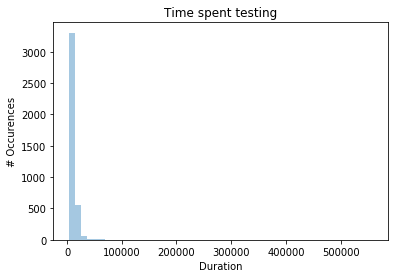

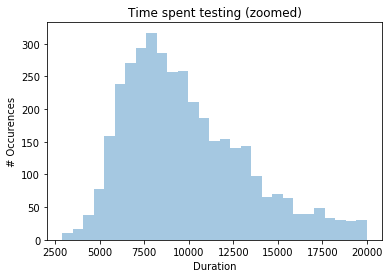

In [21]:
#Describe all the results
multi_start_cnt = 0
multi_finish_cnt = 0
incomplete_cnt = 0
one_test_cnt = 0
pass_times = []
fail_times = []

for key in start_time_map.keys():

    # Count the incomplete folks
    if key not in pass_time_map and key not in fail_time_map:
        incomplete_cnt += 1
            
    # Count the folks who started multiple times?
    elif len(start_time_map[key]) >= 2:
        multi_start_cnt += 1
        if len(pass_time_map[key]) + len(fail_time_map[key]) >= 2:
            multi_finish_cnt += 1
                        
    elif len(pass_time_map[key]) + len(fail_time_map[key]) >= 2:
        print(f"Error, user {key} has >= 2 ends but only 1 start")
            
    # Profile the folks who tested once
    else:
        one_test_cnt += 1
        if len(pass_time_map[key]) == 1:
            pass_times.append(pass_time_map[key][0] - start_time_map[key][0])
        elif len(fail_time_map[key]) == 1:
            fail_times.append(fail_time_map[key][0] - start_time_map[key][0])

test_times = pass_times + fail_times
            
#Clean up the data
clean, num_less, num_more = reject_outliers(np.array(test_times))
    
print(f"There were {multi_start_cnt} people that started an eligibility test multiple times, " 
      + f"and {multi_finish_cnt} people who finished an eligibility test multiple times.")
print(f"There were {incomplete_cnt} people who started but didn't finish a test. ")
print(f"Amongst {one_test_cnt} people who tested once," 
      + f" average test length is {np.average(clean)}, with " + 
      f"{num_less} outliers below and {num_more} outliers above.")
    

#Plot everything
fig = sns.distplot(clean, kde=False, norm_hist = False)
plt.title("Time spent testing")
plt.xlabel("Duration")
plt.ylabel("# Occurences")
plt.savefig("/scratch/PI/euan/projects/mhc/code/daniel_code/aws/figures/eligibility_test.png")
plt.show()


#Plot small bit
plt.figure()
fig = sns.distplot(clean[clean < 20000], kde=False, norm_hist = False)
plt.title("Time spent testing (zoomed)")
plt.xlabel("Duration")
plt.ylabel("# Occurences")
plt.savefig("/scratch/PI/euan/projects/mhc/code/daniel_code/aws/figures/eligibility_test_zoom.png")
plt.show()

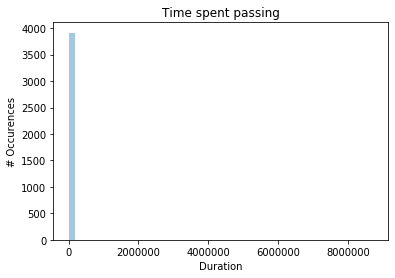

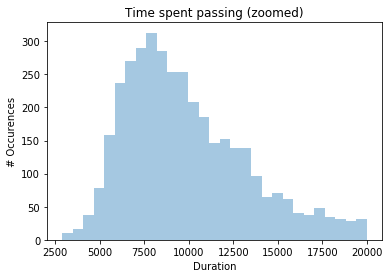

In [23]:
#Plot everything
pass_times = np.array(pass_times)
fig = sns.distplot(pass_times, kde=False, norm_hist = False)
plt.title("Time spent passing")
plt.xlabel("Duration")
plt.ylabel("# Occurences")
#plt.savefig("/scratch/PI/euan/projects/mhc/code/daniel_code/aws/figures/eligibility_test.png")
plt.show()


#Plot small bit
plt.figure()
fig = sns.distplot(pass_times[pass_times < 20000], kde=False, norm_hist = False)
plt.title("Time spent passing (zoomed)")
plt.xlabel("Duration")
plt.ylabel("# Occurences")
#plt.savefig("/scratch/PI/euan/projects/mhc/code/daniel_code/aws/figures/eligibility_test_zoom.png")
plt.show()

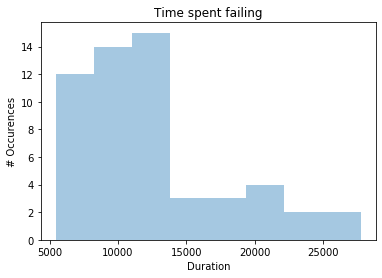

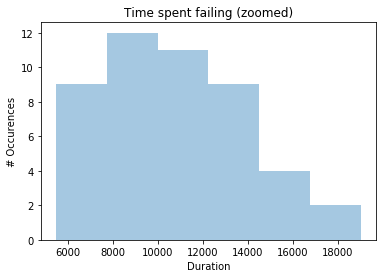

In [24]:
#Plot everything
pass_times = np.array(fail_times)
fig = sns.distplot(pass_times, kde=False, norm_hist = False)
plt.title("Time spent failing")
plt.xlabel("Duration")
plt.ylabel("# Occurences")
#plt.savefig("/scratch/PI/euan/projects/mhc/code/daniel_code/aws/figures/eligibility_test.png")
plt.show()


#Plot small bit
plt.figure()
fig = sns.distplot(pass_times[pass_times < 20000], kde=False, norm_hist = False)
plt.title("Time spent failing (zoomed)")
plt.xlabel("Duration")
plt.ylabel("# Occurences")
#plt.savefig("/scratch/PI/euan/projects/mhc/code/daniel_code/aws/figures/eligibility_test_zoom.png")
plt.show()

In [18]:
#Count global statistics
start_cnt = []
for key in start_times.keys():
    start_cnt.append(len(start_times[key]))

pass_cnt = []
for key in pass_times.keys():
    pass_cnt.append(len(pass_times[key]))
    
fail_cnt = []
for key in fail_times.keys():
    fail_cnt.append(len(fail_times[key]))

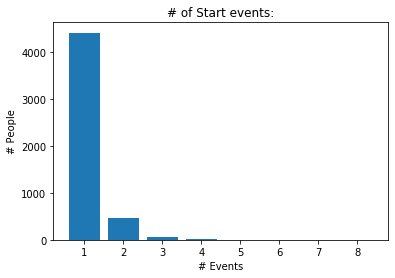

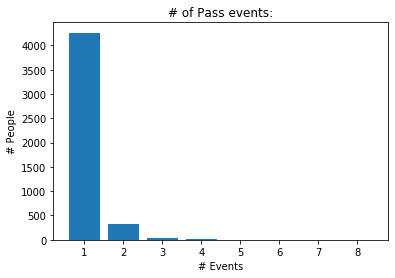

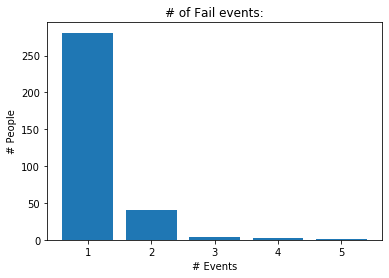

In [22]:
from collections import Counter

plt.figure()
plt.title("# of Start events:")
plt.bar(list(Counter(start_cnt).keys()), list(Counter(start_cnt).values()))
plt.xlabel("# Events")
plt.ylabel("# People")
plt.show()

plt.figure()
plt.title("# of Pass events:")
plt.bar(list(Counter(pass_cnt).keys()), list(Counter(pass_cnt).values()))
plt.xlabel("# Events")
plt.ylabel("# People")
plt.show()

plt.figure()
plt.title("# of Fail events:")
plt.bar(list(Counter(fail_cnt).keys()), list(Counter(fail_cnt).values()))
plt.xlabel("# Events")
plt.ylabel("# People")
plt.show()

# Make some graphs

In [ ]:
healthcode_map = map_aws_to_healthcode()
#age_activity(healthcode_map)

#page_duration()

most_active = usage_graph(healthcode_map)

journey_map(healthcode_map, most_active)